## Sochastic simulation algorithm (SSA)
Jens Hahn  -  06/06/2016


Last time we have talked about ODE modelling, which is a **deterministic** and **continuous** way of modelling. This time, we'll talk about a completely different approach, a **stochastic** and **discrete** simulation. Firstly, this means we get a slightly different result, everytime we run the simulation. Secondly, this means we talk about single molecules and not a vague float value that needs to be interpreted to a molecule count. 

### Gillespie's algorithm
#### Idea behind
The idea of Gillespie's algorithm is to take into account every reaction event, based on molecule collisions and reaction radii around the molecules. It then asks two questions:

1. Considering all probabilities, **when** does the next reaction event takes place?
2. **Which** reaction takes actually place?

#### Let's get started
We start with a specific parameter, called $c$, the average probability that a reactant molecule will react per unit time. The next parameter we need is called $h$, the number of distinct molecular reactant combinations for a given reaction at time t. Finally, we need the distinct time interval we're focus on, we call it $\delta t$.

To answer the questions **1.** and **2.** we need 2 random numbers **r** from a uniform distribution. The first **r1** one we use to calculate a number from the exponential distribution: 
$$ \text{time} = - \frac{1}{a}\times\ln(r1) $$
The second, **r2** we use to get the reaction. We normalise the probabilites to make the sum equal 1. Then we use the random number to get the reaction that will take place next. 

In [119]:
import math
import numpy as np
import matplotlib.pyplot as pyp
%matplotlib inline

In [120]:
# S -> P*S - B*S*Z - d*S
S = 500
# Z -> B*S*Z + G*R - A*S*Z
Z = 0
# R -> d*S - G*R
R = 0

P = 0.0001  # birth rate
d = 0.01  # 'natural' death percent (per day)
B = 0.0095  # transmission percent  (per day)
G = 0.001  # resurect percent (per day)
A = 0.005  # destroy percent  (per day)

t = 0
tend = 20

timecourse = [0]
S_tc = [S]
Z_tc = [Z]
R_tc = [R]

while t < tend:    
    # calculate h_i
    h_birth = (S*(S-1)/2)
    h_death = S
    h_transmission = S*Z
    h_resurrect = R
    h_destroy = S*Z
    
    R_sum = sum([h_birth*P, h_death*d, h_transmission*B, h_resurrect*G, h_destroy*A])
    #print(R_sum)
    a_birth = h_birth*P/R_sum
    #print('a_birth: ',a_birth)
    a_death = h_death*d/R_sum
    #print('a_death: ', a_death)
    a_transmission = h_transmission*B/R_sum
    #print('a_transmission: ', a_transmission)
    a_resurrect = h_resurrect*G/R_sum
    #print('a_resurrect: ', a_resurrect)
    a_destroy = h_destroy*A/R_sum
    #print('a_destroy: ', a_destroy)
    
    a = [a_birth, a_death, a_transmission, a_resurrect, a_destroy]
    a_sum = sum(a)
    
    r1 = np.random.uniform()
    t += - (1./R_sum)*math.log(r1)
    timecourse.append(t)
    
    r2 = np.random.uniform()   
        
    if r2 > 0 and r2 < sum(a[:1]):  # birth
        S += 1
        #print('birth')
    elif r2 > sum(a[:1]) and r2 < sum(a[:2]):  # death
        S -= 1
        R += 1
        #print('death')
    elif r2 > sum(a[:2]) and r2 < sum(a[:3]):  # transmission
        S -= 1
        Z += 1
        #print('transmission')
    elif r2 > sum(a[:3]) and r2 < sum(a[:4]):  # resurrect
        R -= 1
        Z += 1
        #print('resurrect')
    else:
        Z -= 1
        R += 1
        #print('destroy')
        
    S_tc.append(S)
    Z_tc.append(Z)
    R_tc.append(R)

Susceptible people:  724
Zombies:  0
Dead people:  118


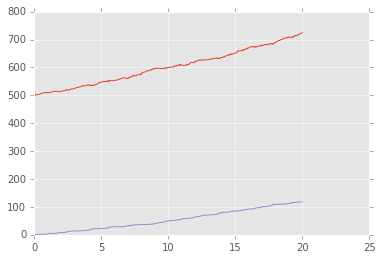

In [121]:
pyp.plot(timecourse, S_tc)
pyp.plot(timecourse, Z_tc)
pyp.plot(timecourse, R_tc)
print('Susceptible people: ', S)
print('Zombies: ', Z)
print('Dead people: ', R)

## Deterministic, continuous solution

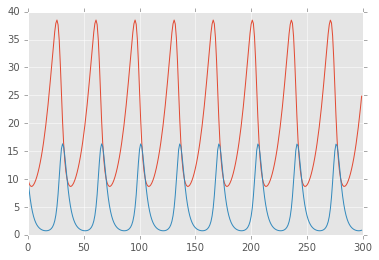

In [122]:
import scipy.integrate
import numpy as np
import math
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

k1 = 0.1
k2 = 0.02
k3 = 0.4
k4 = 0.02

def dSdt( S, t):
    X, Y = S
    dxdt = k1*X - k2*X*Y
    dydt = k4*X*Y - k3*Y
    return [dxdt, dydt]

time = np.arange(0,300,1)
S0 = np.array([10., 10.] )

result = scipy.integrate.odeint( dSdt, S0, time  )
plt.plot( time, result )

## Stochastic, discrete solution

In [ ]:
na = 6.022e23
# species
X = 100
Y = 100
# parameters
k1 = 0.1   # birth X
k2 = 0.02  # eaten X
k3 = 0.4   # death Y
k4 = 0.02  # reproduce Y
# time
t = 0
t_end = 50
# timecourses
timecourse = [0]
X_tc = [X]
Y_tc = [Y]
# loop
while t < t_end:
    h_k1 = X*(X-1)/2
    h_k2 = X*Y
    h_k3 = Y
    h_k4 = X*Y
    
    R_sum = sum([h_k1*k1, h_k2*k2, h_k3*k3, h_k4*k4])

    a_k1 = h_k1*k1/R_sum
    a_k2 = h_k2*k2/R_sum
    a_k3 = h_k3*k3/R_sum
    a_k4 = h_k4*k4/R_sum
    a = [a_k1, a_k2, a_k3, a_k4]
    a_sum = sum(a)
    
    r1 = np.random.uniform()
    t += - (1./R_sum)*math.log(r1)
    timecourse.append(t)
    
    r2 = np.random.uniform() 

    if r2 < sum(a[:1]):  # k1
        X += 1
        #print('k1')
    elif r2 > sum(a[:1]) and r2 < sum(a[:2]):  # k2
        X -= 1
        #print('k2')
    elif r2 > sum(a[:2]) and r2 < sum(a[:3]):  # k3
        Y -= 1
        #print('k3')
    else:  # k4
        Y += 1
        #print('k4')
        
    X_tc.append(X)
    Y_tc.append(Y)

In [ ]:
plt.plot( timecourse, X_tc )
plt.plot( timecourse, Y_tc )
print(Y_tc[-10:])
print(X_tc[-10:])

In [14]:
import math
r1 = [(i+1)/10 for i in range(10)]
R_sum = 30
t = [(-(1./R_sum)*math.log(r)) for r in r1]

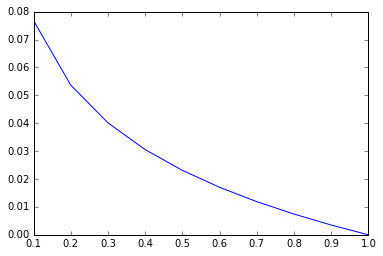

In [15]:
import matplotlib.pyplot as pyp
%matplotlib inline
pyp.plot(r1, t)
pyp.show()